<a href="https://colab.research.google.com/github/Lenferd/pcam_train/blob/lab5/lab-5-learning-transfer/pcam_lab_5_densnet_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras imports

In [22]:
import os
import numpy as np
import tensorflow as tf
%pip install keras-metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load dataset

In [32]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DL_PCAM')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

In [0]:
from keras.utils import HDF5Matrix, normalize

x_train = HDF5Matrix(train_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_train = HDF5Matrix(train_y_name, 'y')

x_valid = HDF5Matrix(valid_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test  = HDF5Matrix(test_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_test  = HDF5Matrix(test_y_name, 'y')

# Reshape labels

In [46]:
# Input image dimensions.
input_shape = x_train.shape[1:]

y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))

print('input share:', input_shape)
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

input share: (96, 96, 3)
x_train shape: (262144, 96, 96, 3)
262144 train samples
32768 test samples
y_train shape: (262144, 1)


In [45]:
y_train = y_train.reshape((y_train.shape[0], 1))
print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

y_valid = y_valid.reshape((y_valid.shape[0], 1))
print("1 in valid : {}".format(np.count_nonzero(y_valid == 1)))
print("0 in valid : {}".format(np.count_nonzero(y_valid == 0)))

1 in train : 131072
0 in train : 131072
1 in valid : 16369
0 in valid : 16399


# Prepare Densnet121 model

In [0]:
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras import layers

def denseNet_trained_freezed(input_shape, num_classes=1):
  densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
  for layer in densenet_model.layers:
    layer.trainable = False

  model = Sequential()
  model.add(densenet_model)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(1, activation='sigmoid', name='fc1', kernel_initializer = 'he_normal'))
  return model

In [49]:
model = denseNet_trained_freezed(input_shape)














29089792/29084464 [==============================] - 1s 0us/step



## Densnet info

### Summary

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


### Plot

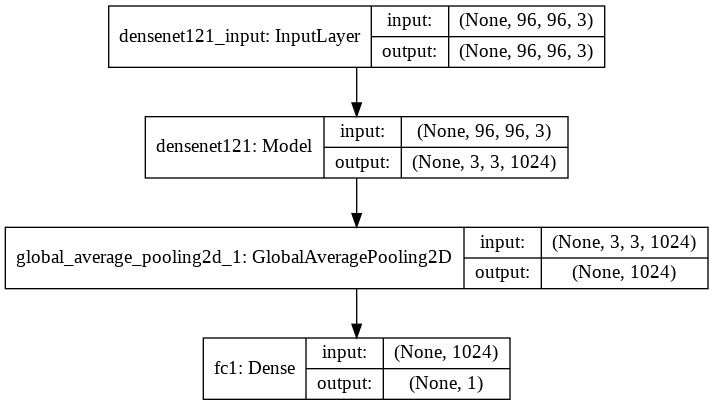

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

#Compile & run model

In [0]:
# PARAMS
LEARN_RATE = 1e-3   # 1e-3
BATCH_SIZE = 256
EPOCHS = 10

In [53]:
from keras.optimizers import Adam
import keras_metrics as k_metrics

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=LEARN_RATE),
              metrics = ['binary_accuracy', 
                          k_metrics.binary_precision(), 
                          k_metrics.binary_recall(),
                          k_metrics.binary_f1_score()
                        ])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [54]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle="batch")


Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 203s 774us/step - loss: 0.6354 - binary_accuracy: 0.6647 - acc: 0.6647 - precision: 0.6647 - recall: 0.6650 - f1_score: 0.6648 - val_loss: 0.5467 - val_binary_accuracy: 0.7181 - val_acc: 0.7181 - val_precision: 0.8591 - val_recall: 0.5215 - val_f1_score: 0.6490
Epoch 2/10
262144/262144 [==============================] - 155s 591us/step - loss: 0.5755 - binary_accuracy: 0.7070 - acc: 0.7070 - precision: 0.7134 - recall: 0.6920 - f1_score: 0.7025 - val_loss: 0.5409 - val_binary_accuracy: 0.7378 - val_acc: 0.7378 - val_precision: 0.7135 - val_recall: 0.7944 - val_f1_score: 0.7518
Epoch 3/10
262144/262144 [==============================] - 152s 581us/step - loss: 0.5666 - binary_accuracy: 0.7149 - acc: 0.7149 - precision: 0.7183 - recall: 0.7071 - f1_score: 0.7126 - val_loss: 0.5583 - val_binary_accuracy: 0.7029 - val_acc: 0.7029 - val_precision: 0.8426 - val_recall: 0.4987 - val

# Metrics

In [0]:
from matplotlib import pyplot

# Prepare metrics functions
def plot_metrics(code_metrics, name_metrics):
    pyplot.plot(history.history[code_metrics])
    pyplot.plot(history.history['val_' + code_metrics])
    pyplot.title('Model ' + name_metrics)
    pyplot.ylabel(name_metrics)
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Test'], loc='upper left')
    pyplot.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))

In [56]:
prediction = model.predict(x_train)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

print(prediction)

>=0.5 (1): 14858
<0.5 (0): 247286
1 in train : 131072
0 in train : 131072
[[0.0532102 ]
 [0.29881576]
 [0.40883076]
 ...
 [0.33076668]
 [0.31077588]
 [0.09341702]]


In [57]:
prediction = model.predict(x_test)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in test : {}".format(np.count_nonzero(y_test == 1)))
print("0 in test : {}".format(np.count_nonzero(y_test == 0)))

print(prediction)

>=0.5 (1): 1724
<0.5 (0): 31044
1 in test : 16377
0 in test : 16391
[[0.01333258]
 [0.31968376]
 [0.11146611]
 ...
 [0.48931426]
 [0.16149119]
 [0.1154702 ]]


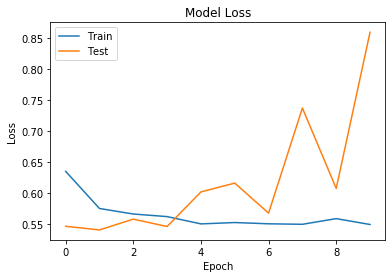

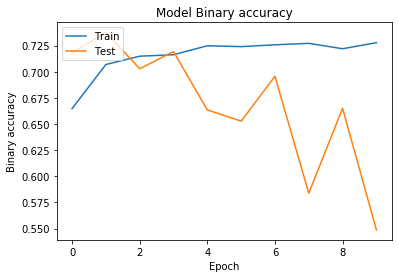

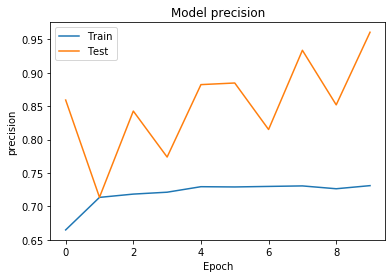

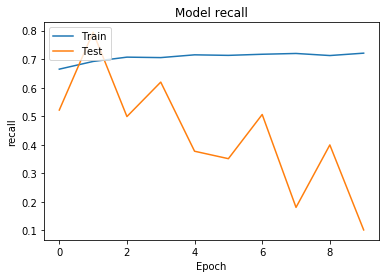

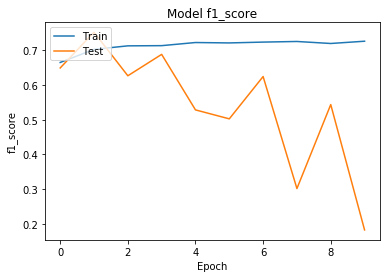

In [58]:
plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Binary accuracy')
plot_metrics('precision', 'precision')
plot_metrics('recall', 'recall')
plot_metrics('f1_score',  'f1_score')

In [59]:
name_model = "densnet121-freezed-weights"
show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)

262144/262144 [==============================] - 259s 987us/step
mobilenet train accuracy : 55.3619384765625
mobilenet train precision : 55.3619384765625
mobilenet train recall : 97.30111724258109
mobilenet train f1-score : 11.029815673819709
32768/32768 [==============================] - 35s 1ms/step
mobilenet valid accuracy : 53.2745361328125
mobilenet valid precision : 53.2745361328125
mobilenet valid recall : 96.1605584558324
mobilenet valid f1-score : 6.732237766468738
32768/32768 [==============================] - 33s 1ms/step
mobilenet test accuracy : 54.8675537109375
mobilenet test precision : 54.8675537109375
mobilenet test recall : 96.0556844491847
mobilenet test f1-score : 10.111742077241793
